# Testing

Using this notebook to test the code used in the dhw calculations

Does so by just working on one time spatial point!



In [2]:
import xarray as xr
from dask.distributed import Client
import dask.array as da
from dask import delayed
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob

#### start a local Dask client

In [3]:
from dask.distributed import Client
import dask

# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

#cluster = LocalCluster(
#    n_workers=28,          # Number of workers
#    threads_per_worker=1 #Threads per worker
#    #memory_limit='8GB' # Memory limit per each worker commented out
#)
#client = Client(cluster)

client = Client()
client

2024-06-30 13:36:03,187 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-06-30 13:36:03,193 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-06-30 13:36:03,200 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-mmem-bdw-0003.gadi.nci.org.au/40197/proxy/8787/status,
Dashboard: /node/gadi-mmem-bdw-0003.gadi.nci.org.au/40197/proxy/8787/status,Workers: 32
Total threads: 32,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43261,Workers: 32
Dashboard: /node/gadi-mmem-bdw-0003.gadi.nci.org.au/40197/proxy/8787/status,Total threads: 32
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37951,Total threads: 1
Dashboard: /node/gadi-mmem-bdw-0003.gadi.nci.org.au/40197/proxy/40339/status,Memory: 0 B
Nanny: tcp://127.0.0.1:39983,


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
coords_to_drop =['st_edges_ocean','nv','st_ocean']
vars_to_drop =['Time_bounds','average_DT','average_T1','average_T2','st_ocean']

# preprocesser to drop unwanted variables
def drop_stuff(ds, coords_to_drop,vars_to_drop):
    """
    Preprocessor function to drop specified coordinates and variables from a dataset loaded via xr.open_mfdataset

    Parameters:
        ds (xarray.Dataset): The dataset from which coordinates & variables are to be dropped.
        coords_to_drop (list of str): List of coordinate names to drop.
        vars_to_drop(list of str): List of variable names to drop

    Returns:
        xarray.Dataset: Dataset with specified coordinates and variables dropped.
    """
    # Drop coordinates if they are in the dataset
    ds = ds.drop_vars(coords_to_drop, errors='ignore')
    ds = ds.drop_vars(vars_to_drop, errors='ignore')
    return ds

In [6]:
def process_threshold(ds, time_dim, start, end, variable, period):
    # Rechunk the data along the time dimension
    data = getattr(ds, variable).sel(**{time_dim: slice(start, end)}).chunk({'Time': -1, 'xt_ocean': 50, 'yt_ocean': 50}).persist()

    # Debug: Print the shape and chunking of the data
    print(f"Processing period {period}, data shape: {data.shape}, chunks: {data.chunks}")

    # Calculate the 90th percentile
    percentile_90 = data.groupby('Time.month').quantile(0.9, dim='Time').compute()
    percentile_90 = data.groupby('Time.dayofyear').quantile(0.9, dim='Time').compute()

    # Convert the result back to an xarray DataArray
    percentile_90_da = xr.DataArray(
        percentile_90,
         coords={
            'xt_ocean': data.coords['xt_ocean'],
            'yt_ocean': data.coords['yt_ocean'],
            'month': np.arange(1, 13)
        },
        dims=['dayofyear', 'yt_ocean', 'xt_ocean']
    )

    # Define the output file path
    file_path_90th = f'/g/data/ia39/ncra/ocean/peacey/{variable}_percentile_monthly__{period}.nc'

    # Save 90th percentile as netCDF
    percentile_90_da.to_netcdf(file_path_90th, compute=True)

In [7]:
# Define the periods for processing
GWL_periods = {
    'current': ('1995-01-01', '2014-12-31'),
    'GW1p2': ('2001-01-01', '2020-12-31'),
    'GW1p5': ('2015-01-01', '2034-12-31'),
    'GW2p0': ('2030-01-01', '2049-12-31'),
    'GW3p0': ('2053-01-01', '2072-12-31'),
    'GW4p0': ('2074-01-01', '2093-12-31')
}

# Directory paths for SST
dir1_new = '/g/data/fp2/OFAM3/jra55_historical.1/surface/'
dir2_new = '/g/data/fp2/OFAM3/jra55_rcp8p5/surface/'

# Load datasets with chunking
pattern0=sorted(glob(dir1_new + 'ocean_temp_sfc*.nc'))
# need to get the additional data from historical run to cover the early 2000s
pattern1=sorted(glob(dir1_new + 'ocean_temp_sfc*200[0-5]*.nc'))
pattern2=sorted(glob(dir2_new + 'ocean_temp_sfc*.nc'))

dsst1 = xr.open_mfdataset(pattern0, parallel=True, 
        preprocess = lambda x: drop_stuff(x,coords_to_drop, vars_to_drop)).squeeze()
dsst2 = xr.open_mfdataset(pattern1+pattern2, parallel=True, 
        preprocess = lambda x: drop_stuff(x,coords_to_drop, vars_to_drop)).squeeze()


In [8]:
dsst2

<xarray.Dataset> Size: 805GB
Dimensions:   (Time: 37255, yt_ocean: 1500, xt_ocean: 3600)
Coordinates:
  * Time      (Time) datetime64[ns] 298kB 2000-01-01T12:00:00 ... 2101-12-31T...
  * xt_ocean  (xt_ocean) float64 29kB 0.05 0.15 0.25 0.35 ... 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 12kB -74.95 -74.85 -74.75 ... 74.75 74.85 74.95
Data variables:
    temp      (Time, yt_ocean, xt_ocean) float32 805GB dask.array<chunksize=(31, 1500, 3600), meta=np.ndarray>
Attributes:
    filename:       TMP/ocean_ofam_2000_01.nc.0000
    NumFilesInSet:  1350
    title:          jra_55_1979
    grid_type:      regular
    history:        Wed Mar 25 10:28:06 2015: ncks -d st_ocean,0 ../daily/oce...
    NCO:            4.3.8

## Playing 

In [9]:
sst=dsst2.temp

In [10]:
# select a point to test the MHW code
xlat=10; xlon= 190
sst1 = sst.sel(yt_ocean=xlat, xt_ocean=xlon, method='nearest')
#sst1=sst
sst1 = sst1.rename({"Time":"time"})
sst1= sst1.sel(time=slice('2001-01-01', '2020-12-31'))

# number of years in the slice
nshape= np.shape(sst1)
nyears=np.int(nshape[0]/365.25+.5)
print(nyears)

sst1

20


<xarray.DataArray 'temp' (time: 7305)> Size: 29kB
dask.array<getitem, shape=(7305,), dtype=float32, chunksize=(31,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 58kB 2001-01-01T12:00:00 ... 2020-12-31T1...
    xt_ocean  float64 8B 190.1
    yt_ocean  float64 8B 10.05
Attributes:
    long_name:      Potential temperature
    units:          degrees C
    valid_range:    [-32767  32767]
    packing:        4
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

In [13]:
%%time
#threshold90 =  xr.open_dataset('/g/data/ia39/ncra/ocean/peacey/mhw/temp_90th_percentile_current.nc')['temp']
threshold90 =  xr.open_dataset('/g/data/ia39/ncra/ocean/mhw/temp_90th_percentile_GW1p2.nc')['temp']
#threshold90 = threshold90.chunk({'yt_ocean': 50, 'xt_ocean': 50})
# check whether I need to select
threshold90 = threshold90.sel(yt_ocean=xlat, xt_ocean=xlon, method='nearest')
threshold90

CPU times: user 77.4 ms, sys: 48.5 ms, total: 126 ms
Wall time: 196 ms


<xarray.DataArray 'temp' (dayofyear: 366)> Size: 3kB
[366 values with dtype=float64]
Coordinates:
    xt_ocean   float64 8B 190.1
    yt_ocean   float64 8B 10.05
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Attributes:
    long_name:      Potential temperature
    units:          degrees C
    valid_range:    [-32767  32767]
    packing:        4
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

CPU times: user 22 µs, sys: 0 ns, total: 22 µs
Wall time: 47.7 µs


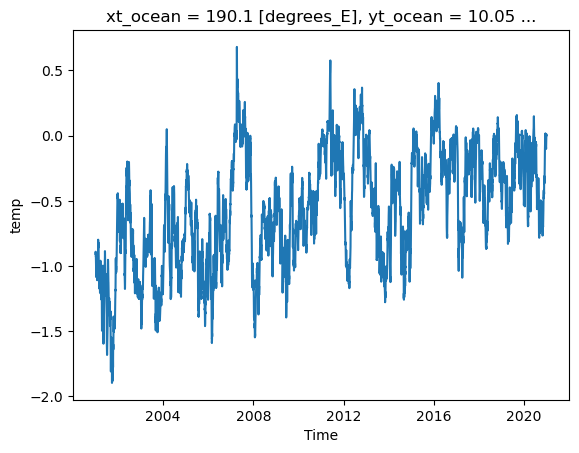

In [14]:
# MHW 
%time

# Expand threshold90 to match the original time series, and dropping "dayofyear"
expanded_threshold = threshold90.sel(dayofyear=sst1['time'].dt.dayofyear)
expanded_threshold = expanded_threshold.drop('dayofyear')


# Calculate anomolies and plot
diff = sst1 - expanded_threshold
diff.plot()

In [15]:
%%time
min_dur=10
hmask= sst1 > expanded_threshold
# must satisfy min_dur with the shift required to get all the times
hmask1 = hmask.rolling(time=min_dur, center=False).sum() >= min_dur
hmask2 = hmask1.shift(time=((min_dur-1)*-1),fill_value=False)

hmask3= hmask1 | hmask2

CPU times: user 147 ms, sys: 40.1 ms, total: 187 ms
Wall time: 205 ms


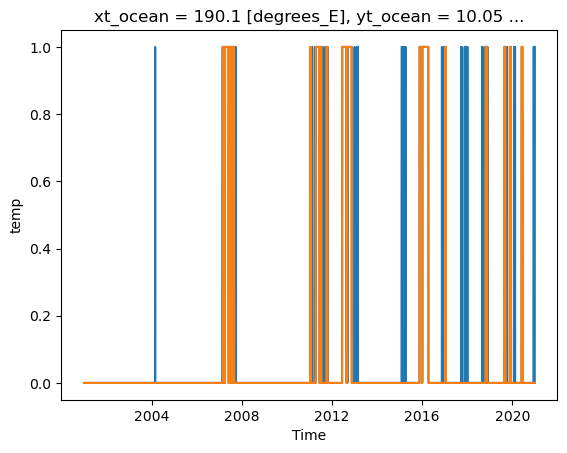

In [16]:
hmask.plot()
hmask3.plot()

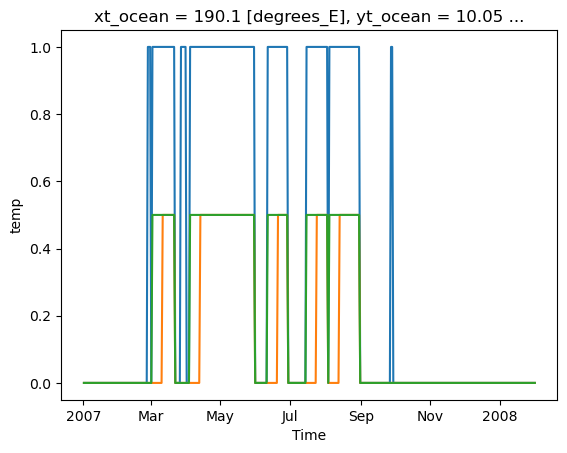

In [17]:
# extra plotting and printing to assess the output 
# show the need to extend the length of the MHW with shift
hmask.sel(time=slice('2007-01-01', '2008-01-31')).plot()
(hmask1.sel(time=slice('2007-01-01', '2008-01-31'))*.5).plot()
(hmask3.sel(time=slice('2007-01-01', '2008-01-31'))*.5).plot()

In [18]:
nmask=hmask.astype(int)
nmask1=hmask3.astype(int)

atmp=nmask.sel(time=slice('2007-02-01', '2007-04-30')).values
btmp=nmask1.sel(time=slice('2007-02-01', '2007-04-30')).values

nl=np.shape(atmp)

for n in range(nl[0]):
    print(atmp[n], btmp[n])

0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
1 0
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0
1 0
0 0
0 0
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


In [19]:
%%time
# duration in days/y and mean magnitude over all heatwaves in period
dur_mhw=(hmask3.sum('time')/nyears).compute()
mag_mhw=( (hmask3*diff).mean('time')/dur_mhw).compute()

print(dur_mhw.values  )  
print(mag_mhw.values  )  

28.25
0.0003618416572431207
CPU times: user 24.4 s, sys: 2.08 s, total: 26.5 s
Wall time: 28.3 s


In [20]:
a=dur_mhw.rename('duration')
a
#dur_mhw= dur_mhw.rename(temp=mhw_duration)
#dur_mhw

<xarray.DataArray 'duration' ()> Size: 8B
array(28.25)
Coordinates:
    xt_ocean  float64 8B 190.1
    yt_ocean  float64 8B 10.05

In [ ]:
a.to_netcdf("/scratch/xv83/rxm599/tmp_.nc")

In [ ]:
client.close()